# 202020892_박경민_인공지능기초_중간대체과제
실행환경 : Python Version 3.10.13

1. MNIST 데이터셋 로딩 및 초기 환경 설정

In [11]:

!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py     #pytorchcv.py 파일에서 함수 가져오기
%pip install torchvision    # torchvision 라이브러리 설치. 유용한 데이터셋, 모델 아키텍처 및 이미지 변환 도구 포함
%pip install torchinfo      # torchvision 라이브러리 설치. 유용한 데이터셋, 모델 아키텍처 및 이미지 변환 도구 포함
%pip install pytorchcv      # pytorchcv 라이브러리 설치. 추가적인 컴퓨터 비전 관련 유틸리티 제공



# 필요한 라이브러리들 임포트
import gzip
import pickle
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim

# pytorchcv에서 제공하는 load_mnist 함수를 사용하여 MNIST 데이터셋 로드
# 이 함수는 데이터를 로딩하고, 훈련 데이터와 테스트 데이터로 나누며, DataLoader 객체를 생성
from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128) 

--2024-04-18 15:09:44--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.2’

pytorchcv.py.2      100%[===================>]   6.39K  --.-KB/s    in 0.001s  

2024-04-18 15:09:44 (7.55 MB/s) - ‘pytorchcv.py.2’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2.  Fashion-MNIST 데이터 로드 및 데이터셋 처리

Train dataset size: 8000
Test dataset size: 2000


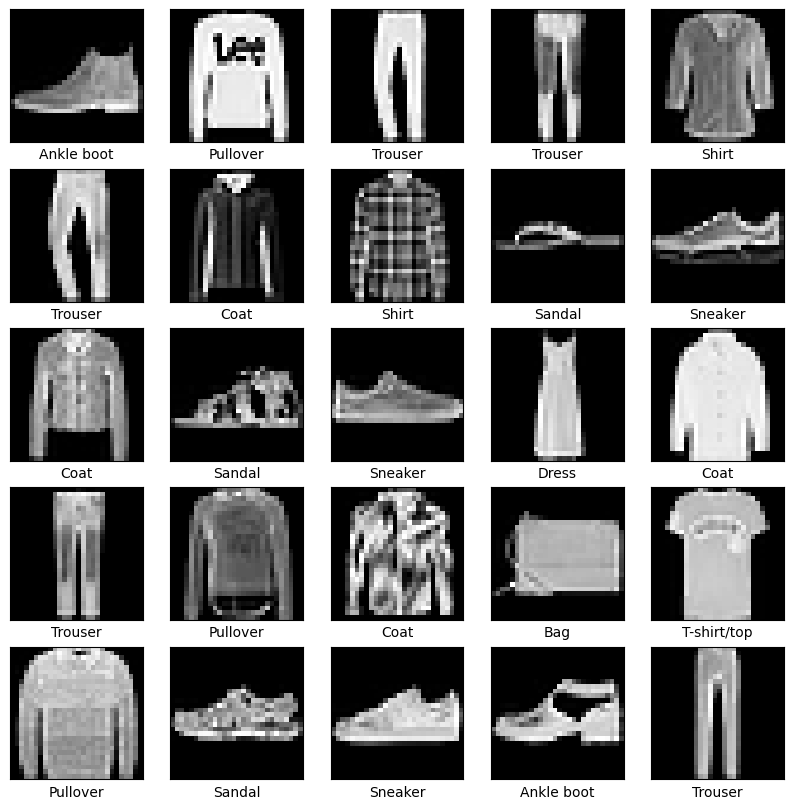

In [12]:
# Fashion-MNIST 이미지 데이터 로드
with gzip.open("/workspaces/introai202401-midterm-Korinee/t10k-images-idx3-ubyte.gz", 'rb') as f1:
    image_content = np.frombuffer(f1.read(), np.uint8, offset=16)
    image_data = image_content.reshape(-1, 28, 28).astype(np.float32)
    image_data = image_data / 255.0

# Fashion-MNIST 라벨 데이터 로드
with gzip.open("/workspaces/introai202401-midterm-Korinee/t10k-labels-idx1-ubyte.gz", 'rb') as f2:
    label_data = np.frombuffer(f2.read(), np.uint8, offset=8)
    label_data = label_data.astype(np.int64)

# 데이터 크기 설정
n = 10000   # 데이터 총 개수 설

# 데이터를 훈련용과 테스트용으로 분할
train_image, test_image = np.split(image_data, [n * 8 // 10])
train_label, test_label = np.split(label_data, [n * 8 // 10])

# 클래스 레이블 설정
classes = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}


# 이미지 및 라벨 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images        # 이미지 데이터
        self.labels = labels        # 라벨 데이터
        self.transform = transform  # 변환 함수

    def __len__(self):
        return len(self.images)     # 데이터셋의 길이 반환

    def __getitem__(self, idx):
        image = self.images[idx]    # 특정 인덱스의 이미지
        label = self.labels[idx]    # 특정 인덱스의 라벨

        if self.transform:
            image = self.transform(image)   # 변환 함수 적용

        return image, label

# 이미지를 텐서로 변환하는 변환 정의
transform = transforms.ToTensor()

# 사용자 정의 데이터셋 생성
train_dataset = CustomDataset(train_image, train_label, transform=transform)
test_dataset = CustomDataset(test_image, test_label, transform=transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 데이터셋 크 출력
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# 데이터셋 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(train_dataset[i][0].squeeze(), cmap='gray')  # 이미지 텐서를 2D로 변환하여 표시
    plt.xlabel(classes[train_dataset[i][1]])  # 이미지 아래에 클래스 라벨을 표시
plt.show()

3. PyTorch를 사용한 간단한 신경망 모델의 정의 및 요약

In [13]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


4. PyTorch를 사용하여 신경망 모델의 훈련 및 검증 과정 구현

In [14]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



5. PyTorch를 사용한 신경망 모델의 학습 및 결과 처리 과정

Epoch 1/5: Train Loss: 0.0068, Train Acc: 70.30%, Test Loss: 0.0048, Test Acc: 78.10%
Epoch 2/5: Train Loss: 0.0043, Train Acc: 80.39%, Test Loss: 0.0040, Test Acc: 82.55%
Epoch 3/5: Train Loss: 0.0037, Train Acc: 83.38%, Test Loss: 0.0037, Test Acc: 84.45%
Epoch 4/5: Train Loss: 0.0034, Train Acc: 84.78%, Test Loss: 0.0037, Test Acc: 83.60%
Epoch 5/5: Train Loss: 0.0032, Train Acc: 86.10%, Test Loss: 0.0035, Test Acc: 84.95%


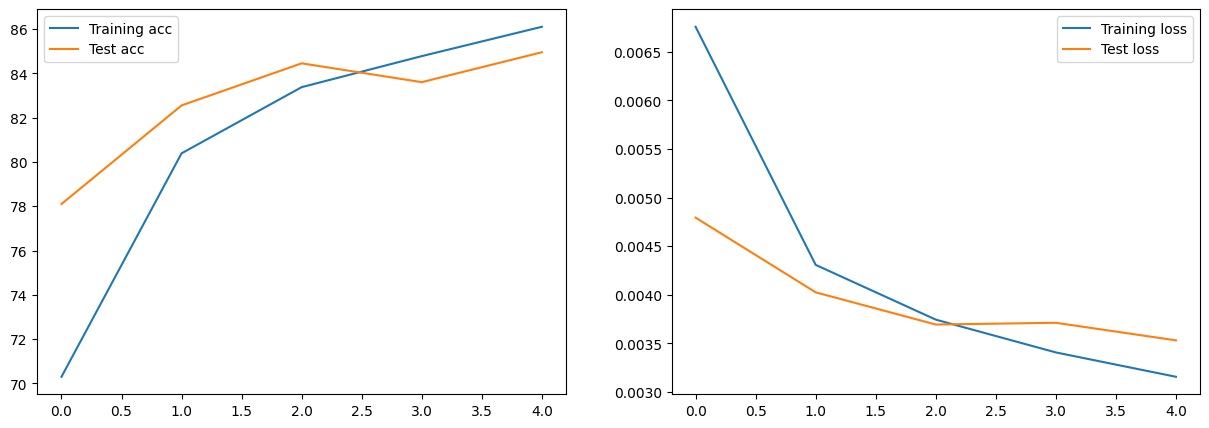

In [15]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌
### 실제 train이 일어나는 곳

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 변수에 저장
hist = train(net,train_loader,test_loader,epochs=5)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

6. SimpleCNN - PyTorch를 이용한 간단한 CNN 모델 정의

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()       # nn.Module의 생성자를 호출하여 클래스 초기화
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)     # 첫 번째 컨볼루션 레이어 정의. 1개의 입력 채널, 16개의 출력 채널.
        self.pool = nn.MaxPool2d(2, 2)          # 최대 풀링 레이어 정의. 2x2 풀링 윈도우를 사용.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)    # 두 번째 컨볼루션 레이어 정의. 16개의 입력 채널, 32개의 출력 채널.
        self.fc1 = nn.Linear(32 * 7 * 7, 128)   # 첫 번째 완전 연결 레이어 정의. 입력 특성 1568개(32*7*7), 출력 특성 128개.
        self.fc2 = nn.Linear(128, 10)           # 두 번째 완전 연결 레이어 정의. 입력 특성 128개, 출력 특성 10개(클래스 수).

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 첫 번째 컨볼루션 레이어를 적용하고, ReLU 활성화 함수를 사용한 후 풀링 적용.
        x = self.pool(F.relu(self.conv2(x)))    # 두 번째 컨볼루션 레이어를 적용
        x = x.view(-1, 32 * 7 * 7)              # 다차원 텐서를 1차원으로 펼치기
        x = F.relu(self.fc1(x))                 # # 첫 번째 완전 연결 레이어와 ReLU 활성화 함수를 통과
        x = self.fc2(x)
        return x

7. PyTorch를 사용한 CNN 모델의 훈련 및 평가

In [17]:
def train_and_evaluate(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()                       # 손실 함수로 Cross Entropy Loss 사용
    optimizer = optim.Adam(model.parameters(), lr=0.001)    # 최적화 알고리즘으로 Adam 사용, 학습률은 0.001

    # Training
    model.train()       # 모델을 훈련 모드로 설정
    for epoch in range(epochs):     # 지정된 에폭 수만큼 반복
        for data, target in train_loader:    # 학습 데이터 로더를 통해 데이터와 레이블 가져오기
            data, target = data.to(device), target.to(device)   # 데이터와 레이블을 계산을 위해 디바이스로 이동
            optimizer.zero_grad()   # 기울기를 0으로 초기화
            output = model(data)    # 모델에 데이터를 전달하여 출력 계산
            loss = criterion(output, target)    # 손실 계산
            loss.backward()                     # 역전파 실행
            optimizer.step()                    # 최적화 단계에서 매개변수 업데이트
        print(f"Epoch {epoch+1} completed.")    # 현재 에폭 완료 메시지 출력

    # Evaluation
    model.eval()        # 모델을 평가 모드로 설정
    correct = 0         # 올바르게 예측된 데이터 수
    total = 0           # 전체 데이터 수
    with torch.no_grad():   # 기울기 계산을 하지 않음
        for data, target in test_loader:    # 테스트 데이터 로더를 통해 데이터와 레이블 가져오기
            data, target = data.to(device), target.to(device)   # 데이터와 레이블을 디바이스로 이동
            outputs = model(data)           # 모델에 데이터를 전달하여 출력 계산
            _, predicted = torch.max(outputs.data, 1)           # 가장 높은 값의 인덱스를 예측 값으로 선택
            total += target.size(0)         # 처리된 데이터의 총 수 업데이트
            correct += (predicted == target).sum().item()       # 정확하게 예측된 데이터의 수 업데이트

    print(f'Accuracy: {100 * correct // total}%')               # 정확도 계산 및 출력

# 모델 생성 및 훈련/평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # CUDA가 가능한 경우 GPU 사용, 그렇지 않으면 CPU 사용
model = SimpleCNN().to(device)                                  # SimpleCNN 모델 인스턴스 생성 및 디바이스에 할당
train_and_evaluate(model, train_loader, test_loader)            # 훈련 및 평가 함수 호출

Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Accuracy: 82%


8. PyTorch를 사용하여 모델의 오분류 분석 및 시각화

Total misclassified images: 346 out of 2000
Error percentage: 17.30%


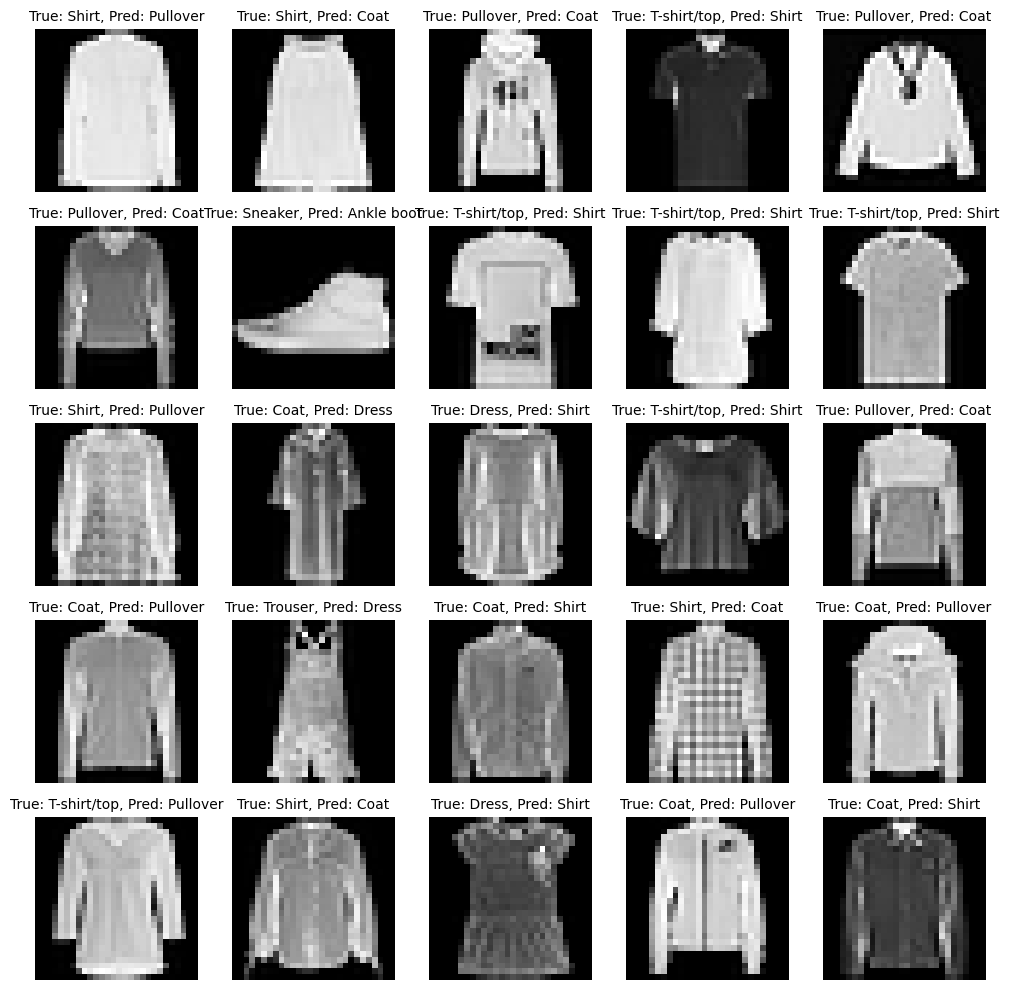

In [18]:
def analyze_misclassifications(model, loader):
    model.eval()    # 모델을 평가 모드로 설정
    confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)   # 10x10 크기의 혼동 행렬 초기화
    misclassified_images = []       # 오분류된 이미지를 저장할 리스트
    misclassified_labels = []       # 오분류된 이미지의 실제 레이블을 저장할 리스트
    misclassified_predictions = []  # 오분류된 이미지의 예측 레이블을 저장할 리스트
    total_images = 0                # 전체 이미지 수
    misclassified_count = 0         # 오분류된 이미지 수

    with torch.no_grad():           # 기울기 계산 비활성화
        for images, labels in loader:   # 데이터 로더에서 이미지와 레이블을 순차적으로 로드
            images, labels = images.to(device), labels.to(device)   # 이미지와 레이블을 디바이스로 이동
            outputs = model(images)     # 모델에 이미지를 입력하여 출력값 계산
            _, predicted = torch.max(outputs, 1)    # 출력값 중 최댓값의 인덱스를 예측값으로 선택
            for image, label, pred in zip(images, labels, predicted):   # 이미지, 레이블, 예측값을 하나씩 처리
                confusion_matrix[label.item(), pred.item()] += 1        # 혼동 행렬 업데이트
                total_images += 1       # 전체 이미지 수 업데이트
                if label != pred:       # 실제 레이블과 예측 레이블이 다른 경우
                    misclassified_images.append((image, label, pred))   # 오분류된 이미지 정보 저장
                    misclassified_count += 1    # 오분류된 이미지 수 업데이트

    error_percentage = (misclassified_count / total_images) * 100       # 오분류 비율 계산
    print(f'Total misclassified images: {misclassified_count} out of {total_images}')   # 오분류된 이미지 수와 전체 이미지 수 출력
    print(f'Error percentage: {error_percentage:.2f}%')     # 오분류 비율 출력
    return confusion_matrix, misclassified_images, error_percentage     # 혼동 행렬, 오분류된 이미지 리스트, 오분류 비율 반환

# 오분류 분석과 결과 프린트
conf_matrix, misclassified, error_percentage = analyze_misclassifications(model, test_loader)   # 오분류 분석 함수 호출

# 오분류 상위 이미지 표시
plt.figure(figsize=(10, 10))    # 그래프 크기 설정
for i, (img, true_label, pred_label) in enumerate(misclassified[:25]):   # 오분류된 상위 25개 이미지 처리
    plt.subplot(5, 5, i + 1)    # 5x5 그리드에서 각 이미지 위치 지정
    plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')    # 이미지 표시, 차원 감소 및 CPU로 이동
    plt.title(f'True: {classes[true_label.item()]}, Pred: {classes.get(pred_label.item(), "Error")}', fontsize=10)  # 실제 레이블과 예측 레이블 표시
    plt.axis('off') # 축 표시 없앰
plt.tight_layout()  # 서브플롯 간격 조정
plt.show()          # 그래프 표시

9. PyTorch 모델의 오분류 예측 라벨 빈도 분석

Total misclassified images: 346 out of 2000
Error percentage: 17.30%


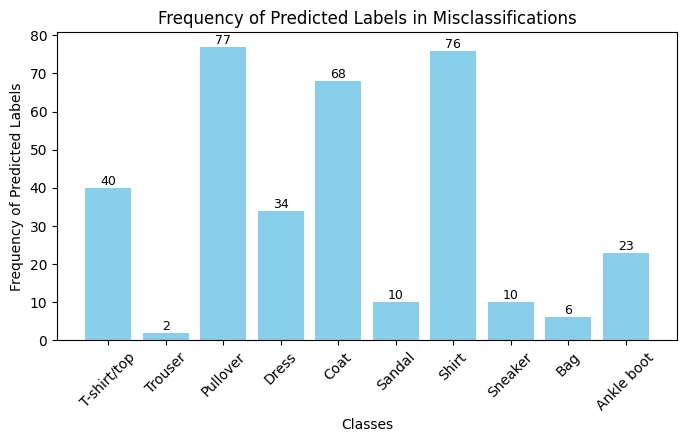

In [24]:
def plot_predicted_frequencies(misclassified_images, classes):
    """ 오분류된 이미지의 예측 라벨 빈도수를 플롯 """
    # 오분류된 이미지에서 예측된 라벨만 추출
    pred_labels = [img[2].item() for img in misclassified_images]

    # 각 라벨의 빈도수 계산
    pred_label_counts = np.bincount(pred_labels, minlength=len(classes))

    # 라벨 이름과 빈도수를 막대 그래프로 표시
    fig, ax = plt.subplots(figsize=(8, 4))  # 그래프 크기 변경
    bars = ax.bar(range(len(classes)), pred_label_counts, color='skyblue')  # 막대 그래프 생성
    
    # 각 막대 위에 빈도수 표시
    for bar, count in zip(bars, pred_label_counts):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(count), va='bottom', ha='center', fontsize=9)

    ax.set_xlabel('Classes')    # X축 라벨 설정
    ax.set_ylabel('Frequency of Predicted Labels')  # Y축 라벨 설정
    ax.set_title('Frequency of Predicted Labels in Misclassifications')     # 그래프 제목 설정
    ax.set_xticks(range(len(classes)))  # X축 틱 설정
    ax.set_xticklabels([classes[i] for i in range(len(classes))], rotation=45)   # X축 라벨을 클래스 이름으로 설정 및 회전
    plt.show()  # 그래프 표시

# 클래스 이름 정의
classes = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

# 오분류된 이미지 분석 및 결과 반환
conf_matrix, misclassified, error_percentage = analyze_misclassifications(model, test_loader)

# 예측된 라벨의 빈도수를 그래프로 표시
plot_predicted_frequencies(misclassified, classes)  